# Value Functions
A policy is a mapping from characteristics to actions. Each environment can be solved by different policies. We can compare effectiveness of each policy using value functions.

1. State Value Function
2. Action Value Function
3. Advantage Value Function

State Value Function - $V_\pi(s)$ 

takes a state as input and outputs expected return we would get if an agent starts starts in the input state and follows policy $\pi$

Action Value Function - $Q_\pi(s,a)$ 

takes a state and action as input and outputs expected return we would get if an agent starts in the input state and takes action a and follows policy $\pi$ after that.

Advantage Value Function is the difference between $Q_\pi(s,a)$ and $V_\pi(s)$


In [1]:
# Imports
import numpy as np
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
np.random.seed(42)

import matplotlib.pyplot as plt
from pprint import pprint
from bsw import BSW

In [2]:
"""
Constants
"""
env = BSW()
gamma = 1.0
theta = 1e-10
# We are evaluating a policy where we always go left
action = 0


In [3]:
"""
State Value Function - MDP's transition function is observable
"""
def state_value_func(action, gamma, theta):
    prev_svf = np.zeros(len(env.bsw_env))
    while True:
        svf = np.zeros(len(env.bsw_env))
        # Access MDP transition function and go through states
        for state in range(len(env.bsw_env)):
            for prob, ns, reward, done in env.bsw_env[state][action]:
                svf[state] += prob * (reward + (gamma * prev_svf[ns] * (not done)))
        if np.max(np.abs(prev_svf - svf)) < theta:
            break
        prev_svf = svf.copy()
    return svf
v = state_value_func(action, gamma, theta)
print(v)

[ 0.0000  0.0023  0.0094  0.0317  0.1014  0.3193  0.0000]


## Estimating Value Functions by Interaction
MDP's transition functions are not always fully observable like in the idle case above. We can interact with the environment, collect trajectories of MDP and estimate state value function from those trajectories. One way to do this is by Monte Carlo First Visit algorithm

In [4]:
"""
State Value Functions - Estimating by interaction
"""
def mcsvf(first_visit=True, num_episodes=1000):
    per_state_returns = np.zeros(len(env.bsw_env))
    per_state_counts = np.zeros(len(env.bsw_env))
    svf_est = np.zeros(len(env.bsw_env))
    prev_svf_est = np.zeros(len(env.bsw_env))
    
    svf_epi = []
    # Scaling factor
    alpha_init = 0.5
    min_alpha = 0.01
    decay_ratio = 0.3
    decay_steps = int(num_episodes * decay_ratio)
    alphas = np.logspace(-2, 0, decay_steps, base=10, endpoint=True)[::-1]
    alphas = (alphas - alphas.min()) / (alphas.max() - alphas.min())
    alphas = (alpha_init - min_alpha) * alphas + min_alpha
    alphas = np.pad(alphas, (0, num_episodes - decay_steps), 'edge')
    
    for i in range(num_episodes):
        state, reward, done = env.reset()
        trajectory = []
        visited = np.zeros(len(env.bsw_env), dtype=bool)
        while not done:
            next_state, reward, done = env.step(action)
            trajectory.append((state, reward))
            state = next_state
        tra_states, tra_rewards = zip(*trajectory)
        gammas = np.array([gamma ** i for i in range(len(trajectory) + 1)])

        for t, s in enumerate(tra_states):
            if visited[s] and first_visit:
                continue
            visited[s] = True
            per_state_counts[s] += 1
            G = np.sum(gammas[:-(1+t)] * tra_rewards[t:])
            svf_est[s] = svf_est[s] + (alphas[i] * (G - svf_est[s]))
        svf_epi.append(svf_est.copy())
    return svf_est, svf_epi

svf_est, svf_epi  = mcsvf(num_episodes=2300)


[ 0.0000  0.0023  0.0094  0.0317  0.1014  0.3193  0.0000]
[ 0.0000  0.0057  0.0087  0.0496  0.1358  0.3364  0.0000]


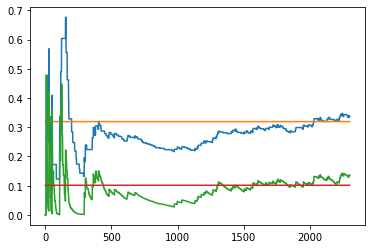

In [5]:
s5 = [svf_epi[i][5] for i in range(len(svf_epi))]
s4 = [svf_epi[i][4] for i in range(len(svf_epi))]
s3 = [svf_epi[i][3] for i in range(len(svf_epi))]
s2 = [svf_epi[i][2] for i in range(len(svf_epi))]
s1 = [svf_epi[i][1] for i in range(len(svf_epi))]
plt.plot(s5)
plt.plot([v[5] for i in range(len(s5))])

plt.plot(s4)
plt.plot([v[4] for i in range(len(s4))])
print(v)
print(svf_est)



In [6]:
def td_learn(num_episodes=10000):    
    td_svf_est = np.zeros(shape=(len(env.bsw_env)))
    
    # Scaling factor
    alpha_init = 0.5
    min_alpha = 0.01
    decay_ratio = 0.3
    decay_steps = int(num_episodes * decay_ratio)
    alphas = np.logspace(-2, 0, decay_steps, base=10, endpoint=True)[::-1]
    alphas = (alphas - alphas.min()) / (alphas.max() - alphas.min())
    alphas = (alpha_init - min_alpha) * alphas + min_alpha
    alphas = np.pad(alphas, (0, num_episodes - decay_steps), 'edge')
    
    td_svf_epi = []
    
    for episode in range(num_episodes):
        state, reward, done = env.reset()
        while not done:
            next_state, reward, done = env.step(action)
            td_target = reward + td_svf_est[next_state] * (not done)
            td_error = td_target - td_svf_est[state]
            td_svf_est[state] += alphas[episode] * td_error
            state = next_state
        td_svf_epi.append(td_svf_est.copy())
    
    return td_svf_est, td_svf_epi
td_svf_est, td_svf_epi = td_learn(2500)
            


    

[ 0.0000  0.0023  0.0094  0.0317  0.1014  0.3193  0.0000]
[ 0.0000  0.0020  0.0082  0.0325  0.1133  0.3201  0.0000]


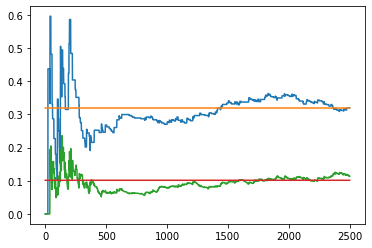

In [7]:
s5 = [td_svf_epi[i][5] for i in range(len(td_svf_epi))]
s4 = [td_svf_epi[i][4] for i in range(len(td_svf_epi))]
s3 = [td_svf_epi[i][3] for i in range(len(td_svf_epi))]
s2 = [td_svf_epi[i][2] for i in range(len(td_svf_epi))]
s1 = [td_svf_epi[i][1] for i in range(len(td_svf_epi))]
plt.plot(s5)
plt.plot([v[5] for i in range(len(s5))])

plt.plot(s4)
plt.plot([v[4] for i in range(len(s4))])
print(v)
print(td_svf_est)



In [11]:
def td_lambda(lambda_=0.3, num_episodes=2500):
    # Scaling factor
    alpha_init = 0.5
    min_alpha = 0.01
    decay_ratio = 0.3
    decay_steps = int(num_episodes * decay_ratio)
    alphas = np.logspace(-2, 0, decay_steps, base=10, endpoint=True)[::-1]
    alphas = (alphas - alphas.min()) / (alphas.max() - alphas.min())
    alphas = (alpha_init - min_alpha) * alphas + min_alpha
    alphas = np.pad(alphas, (0, num_episodes - decay_steps), 'edge')
    
    tdl_svf = np.zeros(len(env.bsw_env))
    elig_trace = np.zeros(len(env.bsw_env))
    tdl_svf_epi = []
    for episode in range(num_episodes):
        elig_trace.fill(0)
        state, reward, done = env.reset()
        while not done:
            next_state, reward, done = env.step(action)
            td_target = reward + gamma * tdl_svf[next_state] * (not done)
            td_error = td_target - tdl_svf[state]
            elig_trace[state] += 1
            tdl_svf += alphas[episode] * td_error * elig_trace
            elig_trace = gamma * lambda_ * elig_trace
            state = next_state
            tdl_svf_epi.append(tdl_svf.copy())
    return tdl_svf, tdl_svf_epi
            
    
tdl_svf, tdl_svf_epi = td_lambda()

[ 0.0000  0.0023  0.0094  0.0317  0.1014  0.3193  0.0000]
[ 0.0000  0.0020  0.0082  0.0325  0.1133  0.3201  0.0000]


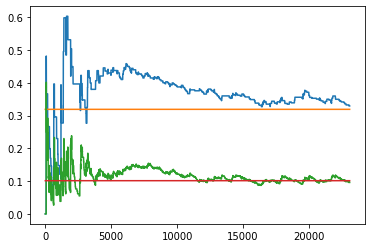

In [12]:
s5 = [tdl_svf_epi[i][5] for i in range(len(tdl_svf_epi))]
s4 = [tdl_svf_epi[i][4] for i in range(len(tdl_svf_epi))]
s3 = [tdl_svf_epi[i][3] for i in range(len(tdl_svf_epi))]
s2 = [tdl_svf_epi[i][2] for i in range(len(tdl_svf_epi))]
s1 = [tdl_svf_epi[i][1] for i in range(len(tdl_svf_epi))]
plt.plot(s5)
plt.plot([v[5] for i in range(len(s5))])

plt.plot(s4)
plt.plot([v[4] for i in range(len(s4))])
print(v)
print(td_svf_est)
